In [11]:
import mlflow
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from pgd_optim_pytorch._utils import filter_df
%matplotlib inline

In [12]:
# Set the tracking URI to the directory containing the mlruns folder
mlflow.set_tracking_uri("../../../mlruns")

# Mutations - other gammas

We will use pSAGD to learn the minima of the CIB for various values of $\gamma$.

## Load and pre-process the data

In [13]:
# Retrieve all runs from the experiment of interest
experiment = mlflow.get_experiment_by_name("Mutations - other gammas")
experiment_id = experiment.experiment_id
print(experiment_id)

278804475068106160


In [14]:
try:
    runs_df = pd.read_csv('mutations_runs_other_gammas.csv')
except FileNotFoundError:
    # Extract df from mlflow directly
    runs_df = mlflow.search_runs(experiment_ids=experiment_id, max_results=100000)
    # Export the DataFrame to a CSV file
    runs_df.to_csv('mutations_runs_other_gammas.csv', index=False)

print(len(runs_df))
print(runs_df.columns)

72
Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.penalty', 'metrics.HcYdoT', 'metrics.CIB loss',
       'metrics.HY', 'metrics.VI of T and T_', 'metrics.HT',
       'metrics.Expected optimal HT', 'metrics.Expected optimal HTcondX',
       'metrics.HTcondX', 'metrics.Final CIB loss', 'metrics.diff_q',
       'metrics.Expected optimal HcYdoT', 'metrics.converged',
       'metrics.Expected optimal CIB loss', 'metrics.diff_loss',
       'params.gamma', 'params.by', 'params.lr', 'params.temperature',
       'params.max iter', 'params.cooling rate', 'params.end_lr_factor',
       'params.Expected optimal q', 'params.beta', 'params.Learned q',
       'params.bs', 'params.eps', 'params.bxi', 'tags.mlflow.user',
       'tags.mlflow.runName', 'tags.mlflow.source.name',
       'tags.mlflow.source.git.commit', 'tags.optimizer',
       'tags.mlflow.source.type', 'tags.loss'],
      dtype='object')


In [15]:
# Add duration metric
runs_df['metrics.duration']=(pd.to_datetime(runs_df['end_time'], format='ISO8601') - pd.to_datetime(runs_df['start_time'], format='ISO8601')).dt.total_seconds()

In [16]:
# Only need some columns
runs = runs_df[[
      'metrics.duration',
      'params.bxi',
      'params.by',
      'params.bs',
      'params.gamma',
      'params.beta',
      'params.lr',
      'metrics.VI of T and T_',
      'metrics.Final CIB loss',
      'metrics.HT',
      'metrics.HTcondX',
      'metrics.HY',
      'metrics.HcYdoT',
      'metrics.converged',
      'params.Learned q',
      'tags.optimizer',
      'tags.loss'
]]

In [17]:
# List of columns that should be float
float_columns = ['params.bxi', 'params.by', 'params.bs', 'params.gamma', 'params.beta', 'params.lr'] 
runs.loc[:, float_columns] = runs[float_columns].apply(pd.to_numeric, errors='raise')

# Remove prefixes
runs.columns = runs.columns.str.split('.').str[1]

# Add MI, Ic columns
runs.loc[:, ['MI_XT']] = runs['HT'] - runs['HTcondX']
runs.loc[:, ['IcYdoT']] = runs['HY'] - runs['HcYdoT']
runs.head()

,duration,bxi,by,bs,gamma,beta,lr,VI of T and T_,Final CIB loss,HT,HTcondX,HY,HcYdoT,converged,Learned q,optimizer,loss,MI_XT,IcYdoT
0,21.069,0.3,0.1,0.5,1.0,inf,10000.0,3.030305e-07,-0.780195,1.432582,-0.000000e+00,2.014693,1.234498,1.0,"tensor([[[[[1., 1.],\n [1., 1.]],\n\...",pSAGD,wCIB+penalty,1.432582,0.780195
1,27.196,0.3,0.1,0.5,1.0,inf,10000.0,-1.738066e-07,-0.780195,1.432582,-0.000000e+00,2.014693,1.234498,1.0,"tensor([[[[[0., 0.],\n [0., 0.]],\n\...",pSAGD,wCIB+penalty,1.432582,0.780195
2,13.991,0.3,0.1,0.5,1.0,inf,10000.0,-1.738066e-07,-0.780195,1.432582,-0.000000e+00,2.014693,1.234498,1.0,"tensor([[[[[0., 0.],\n [0., 0.]],\n\...",pSAGD,wCIB+penalty,1.432582,0.780195
3,29.628,0.3,0.1,0.5,1.0,inf,100.0,5.095053e-01,-0.678923,1.762097,1.582874e-01,2.014693,1.335770,1.0,"tensor([[[[[1.0000, 1.0000],\n [1.00...",pSAGD,wCIB+penalty,1.603809,0.678923
4,29.361,0.3,0.1,0.5,1.0,inf,100.0,3.030305e-07,-0.780195,1.432582,1.625236e-09,2.014693,1.234498,1.0,"tensor([[[[[0., 0.],\n [0., 0.]],\n\...",pSAGD,wCIB+penalty,1.432582,0.780195


Create dataframe with a row containing the best run of each ensemble, i.e., the best run for each $\gamma$.

In [18]:
min_losses = runs.groupby(['gamma'], as_index=False)['Final CIB loss'].min()

# Merge the original DataFrame with the minimum losses DataFrame
df_merged = pd.merge(runs, min_losses, on=['gamma', 'Final CIB loss'])

# Drop duplicates to keep only one row per gamma value
best_runs = df_merged.drop_duplicates(subset=['gamma'])
best_runs

,duration,bxi,by,bs,gamma,beta,lr,VI of T and T_,Final CIB loss,HT,HTcondX,HY,HcYdoT,converged,Learned q,optimizer,loss,MI_XT,IcYdoT
0,21.069,0.3,0.1,0.5,1.0,inf,10000.0,3.030305e-07,-7.801951e-01,1.432582,-0.000000,2.014693,1.234498,1.0,"tensor([[[[[1., 1.],\n [1., 1.]],\n\...",pSAGD,wCIB+penalty,1.432582e+00,0.780195
8,92.130,0.3,0.1,0.5,0.8,4.000000,1.0,1.194096e+00,-2.913416e-01,1.375575,0.558038,2.014693,1.446132,0.0,"tensor([[[[[0.0100, 0.0200],\n [0.02...",pSAGD,wCIB+penalty,8.175371e-01,0.568561
9,92.309,0.3,0.1,0.5,0.6,1.500000,1.0,2.509613e+00,-4.544535e-02,1.813542,1.443461,2.014693,1.692230,0.0,"tensor([[[[[0.1500, 0.1500],\n [0.15...",pSAGD,wCIB+penalty,3.700812e-01,0.322463
10,97.470,0.3,0.1,0.5,0.4,0.666667,1.0,2.905271e+00,1.087763e-01,1.912260,1.685063,2.014693,1.945838,0.0,"tensor([[[[[0.0800, 0.0700],\n [0.07...",pSAGD,wCIB+penalty,2.271972e-01,0.068855
11,70.811,0.3,0.1,0.5,0.2,0.250000,1.0,3.412807e+00,6.942458e-02,1.980015,1.980015,2.014693,2.361816,1.0,"tensor([[[[[0.3100, 0.3100],\n [0.31...",pSAGD,wCIB+penalty,0.000000e+00,-0.347123
13,64.362,0.3,0.1,0.5,0.0,0.000000,1.0,3.405591e+00,-2.384186e-07,1.972860,1.972860,2.014693,2.361816,1.0,"tensor([[[[[0.2700, 0.2700],\n [0.27...",pSAGD,wCIB+penalty,-2.384186e-07,-0.347123


## Parallel plots 

In [19]:
columns_to_plot = ['gamma', 'IcYdoT', 'MI_XT', 'VI of T and T_']

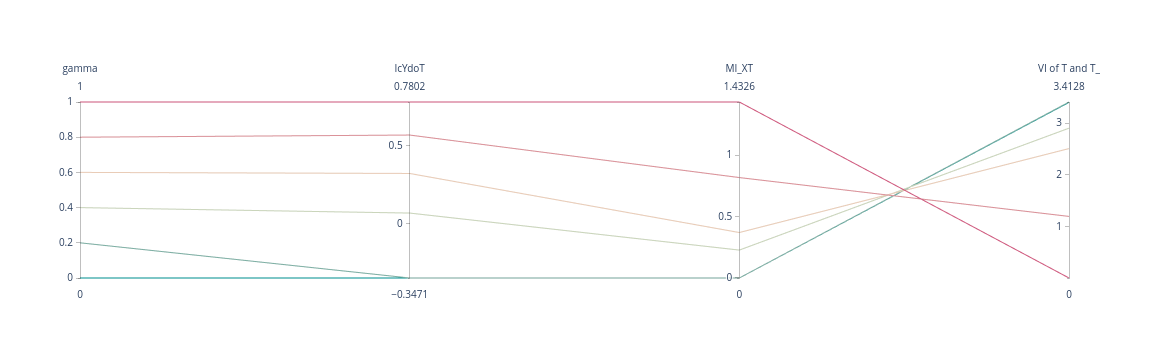

In [20]:
#conditions = (best_runs['converged'] == 1.0) 
conditions = pd.Series([True] * len(best_runs), index=best_runs.index)
filtered_runs = best_runs[conditions]

dimensions = [{'label': col, 'values': filtered_runs[col]} for col in columns_to_plot]
fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            #colorbar=dict(title_text='gamma', tickvals=np.arange(0,1.1,0.2)),
            color=filtered_runs['gamma'], colorscale='TealRose', showscale=False), 
        dimensions=dimensions,
        unselected=dict(line=dict(color='gray', opacity=0.08))
    )
)
# Show the plot
fig.show()

In [21]:
pio.write_image(fig, 'parallel_plot_mutations_other_gammas.pdf', format='pdf', scale=1, width=400, height=300)
pio.write_html(fig, file='parallel_plot_mutations_other_gammas.html', auto_open=False)

Note that, the order expected of the $I_c(Y\mid \mathit{do}(T))$ is respected. Namely, for $\gamma_1 > \gamma_2$, one has that the causal information gain for the encoder learned when $\gamma = \gamma_1$ is larger or equal to that of the encoder learned when $\gamma = \gamma_2$.